# Proof Of Concept - détection anomalies en apprentissage non supervisé séquentiel

Ce notebook est une recherche d'apprentissage non supervisé séquentiel sur un gros dataset : le Los Alamos Natioanal Laboratory "Unified Host and Network Dataset" - ce dataset est l'enregistrement pendant 90 jours de logs machines dans le SI du LANL. Le dataset comporte 90 fichiers, chaque fichier une fois décompressé contient entre 50 et 60 millions de lignes JSON, chacune représentant un évènement machine.

# Idées et recherches :

Le dataset est trop important pour être chargé en mémoire. L'apprentissage est nécessairement séquentiel.
Le dataset n'est pas labelisé, l'apprentissage est nécessairement non supervisé.

Les données sont tabulaires, il y a 22 features. (voir la partie EDA)

Le dataset est traité par batch dans un VAE. Les poids du VAE sont la "mémoire" de l'apprentissage, avec un drift que l'on approchera par une représentation graphique de l'espace latent, choisi en 2D à des fins de représentation.

Chaque nouveau batch est projeté dans l'espace latent. La distribution empirique de probabilité de cette projection est approchée par un KDE (Kernel Density Estimation), et par un modèle Bayesien de Gaussian Mixture Model, ce qui permet d'attribuer une densité de probabilité à chaque point du batch. Cette pdf peut être utilisée pour quantifier une détection.

### Description du LANL Host Dataset

### Article : https://www.worldscientific.com/doi/pdf/10.1142/9781786345646_001

Notes:

"The events from the host logs included in the data set are all related to authentication and process activity on each machine"

### Pour obtenir le dataset:
1- https://csr.lanl.gov/data/2017/#citing : donner mail, obtenir le lien

2- https://csr.lanl.gov/data-fence/... 10 chiffres.../... token... iXYXXbqw15UugRnZALCZ2Y8dvEk=... /unified-host-network-dataset-2017/wls.html pour avoir l'index avec tous les fichiers compressés

3- download : for i in $(seq -w 1 90); do wget -c https://csr.lanl.gov/data-fence/...10 chiffres.../...token.../unified-host-network-dataset-2017/wls/wls_day-$i.bz2; done

4- decompress, as required : bzip2 -dk filename.bz2

### EventID : 

EventID         Description

Authentication events

4768            Kerberos authentication ticket was requested (TGT)

4769            Kerberos service ticket was requested (TGS)

4770            Kerberos service ticket was renewed

4774            An account was mapped for logon

4776            Domain controller attempted to validate credentials

4624            An account successfully logged on, see Logon Types

4625            An account failed to logon, see Logon Types

4634            An account was logged off, see Logon Types

4647            User initiated logoff

4648            A logon was attempted using explicit credentials

4672            Special privileges assigned to a new logon

4800            The workstation was locked

4801            The workstation was unlocked

4802            The screensaver was invoked

4803            The screensaver was dismissed

Process events

4688            Process start

4689            Process end

System events

4608            Windows is starting up

4609            Windows is shutting down

1100            Event logging service has shut down (often recorded instead of EventID 4609)


Detailed description : - EventID : https://learn.microsoft.com/en-us/windows-server/identity/ad-ds/plan/appendix-l--events-to-monitor


### Logon Types for EventIDs: 4624, 4625 and 4634

LogonTypes (EventIDs: 4624, 4625 and 4634)

2 — Interactive

3 — Network

4 — Batch

12 — Cached Remote-Interactive

5 — Service

9 — New Credentials

7 — Unlock

10 — Remote Interactive

8 — Network Clear Text 11 — Cached Interactive

0 — Used only by the system account

### Host Log Fields

. Time: The epoch time of the event in seconds.

• EventID: Four digit integer corresponding to the event id of the record.

• LogHost: The hostname of the computer that the event was recorded on.In the case of directed authentication events, the LogHost will correspond to the computer that the authentication event is terminating at (destination computer).

• LogonType: Integer corresponding to the type of logon, see Table 2.

• LogonTypeDescription: Description of the LogonType, see Table 2.

• UserName: The user account initiating the event. If the user ends in $, then it corresponds to a computer account for the specified computer.

• DomainName: Domain name of UserName.

• LogonID: A semi-unique (unique between current sessions and LogHost)number that identifies the logon session just initiated. Any events logged subsequently during this logon session should report the same LogonID through to the logoff event.

• SubjectUserName: For authentication mapping events, the user account specified by this field is mapping to the user account in UserName.

• SubjectDomainName: Domain name of SubjectUserName.

• SubjectLogonID: See LogonID.

• Status: Status of the authentication request. “0 × 0” means success otherwise failure; failure codes for the appropriate EventID are available online.f

• Source: For authentication events, this will correspond to the the computer where the authentication originated (source computer), if it is a local logon event then this will be the same as the LogHost.

• ServiceName: The account name of the computer or service the user is requesting the ticket for.

• Destination: This is the server the mapped credential is accessing. This may indicate the local computer when starting another process with new account credentials on a local computer.

• AuthenticationPackage: The type of authentication occurring including Negotiate, Kerberos, NTLM plus a few more.

• FailureReason: The reason for a failed logon.

• ProcessName: The process executable name, for authentication events this is the process that processed the authentication event. ProcessNames may include the file type extensions (i.e., exe).

• ProcessID: A semi-unique (unique between currently running processes AND LogHost) value that identifies the process. ProcessID allows you to correlate other events logged in association with the same process through to the process end.

• ParentProcessName: The process executable that started the new process. ParentProcessNames often do not have file extensions like ProcessName but can be compared by removing file extensions from the name.

• ParentProcessID: Identifies the exact process that started the new process. Look for a preceding event 4688 with a ProcessID that matches this ParentProcessID.

# Code

### Bibliothèques

In [1]:
import json
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KernelDensity
from sklearn.mixture import BayesianGaussianMixture

2024-08-06 16:31:03.722078: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 16:31:03.745153: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 16:31:03.839391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 16:31:04.010910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 16:31:04.053729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 16:31:04.164821: I tensorflow/core/platform/cpu_feature_gu

# Exploratory Data Analysis

### Calcul du nombre de lignes des deux premiers fichiers wls_day-01.bz2 et wls_day-02.bz2 une fois décompressés : plus de 50 millions de lignes par fichier

In [2]:
# affiche le nombre de lignes de chaque fichier

def get_lines_number(filepath):
    """retourne le nombre de lignes d'un fichier *.json

    Args:
        filename (_type_): full path filename
    """
    
    with open(filepath) as f:
        ctr_lignes = sum(1 for line in f)
        
    return ctr_lignes

In [3]:
print(os.getcwd())

DIRPATH= os.getcwd() + '/data/'

/home/benjamin/Folders_Python/PoC_Cyber_sequential_learning


In [4]:
dirpath = DIRPATH
liste_fichiers = [ 'wls_day-01_subset_100000.json', 'wls_day-02_subset_all_events_40000.json']

for filename in liste_fichiers:
    filepath = dirpath + filename

    print(f'{filename} contient {get_lines_number(filepath)} lignes')

wls_day-01_subset_100000.json contient 100000 lignes
wls_day-02_subset_all_events_40000.json contient 40000 lignes


### Framework pour le traitement des données

L'idée est d'encoder en "categorical" chaque feature. Pour chaque feature, la classe "FieldRecord" maintient, à la façon d'un dictionnaire, les keys correspondant aux valeurs déjà connues de la feature, l'int correspondant pour l'encodage, ainsi que le nombre d'occurences de la valeurs.

In [5]:
# STRUCTURE DES DONNEES
# ---------------------

# il y a 90 fichiers wls_day-nn.bz2, un pour chaque jour d'enregistrement

# chaque fichier wls_day-nn.bz2 peut se décompresser :
# - via la ligne de commande : bzip2 -dk filename.bz2 (préserve le fichier compressé original)
# - via la bibliothèque python : https://docs.python.org/3/library/bz2.html

# un fichier décompressé est un fichier *.json au format lignes : chaque ligne du fichier est un objet JSON distinct

# chaque objet JSON est un objet à un seul niveau, avec un maximum de 21 paires (key, value)

# ALGORITHME
# ----------

# on va lire les objets JSON un par un (ligne par ligne) et traiter les données séquentiellement.
# chaque champ est managé par un dictionnaire, où :
# - les keys sont les valeurs possibles, déjà vues, du champ
# - les values sont une liste de deux int : 1/ une valeur pour encoder categorical, 2/ un compteur

# PROCESS :
# ---------

# loop sur objets JSON :
# - concaténation de UserName et DomaineName, pour donner un UserNameDomainName qui identifie le user account. Drop UserName, DomaineName
# - pour chacun des 20 champs :
# -- checke si présent dans le JSON object
# ---- si non présent : valeur = -1 (correspond à NaN)
# ---- si présent : regarde dans le dictionnaire du champ
# ------ si existe déjà : retourne valeur, incrémente compteur
# ------ si n'existe pas : crée key, crée nouvelle valeur (= max anciennes + 1), met compteur à 1

In [6]:
# liste des champs à traiter

list_fields = [
    'Time', # int64
    'EventID', # int64
    'LogHost', # object
    'LogonType', # float64, corresponding to the type of logon, see Table 2.
    'LogonTypeDescription', # object Description of the LogonType, see Table 2.
    'UserName', # object - The user account initiating the event. If the user ends in $, then it corresponds to a computer account for the specified computer.
    'DomainName', # object - Domain name of UserName.
    'LogonID', #: object. A semi-unique (unique between current sessions and LogHost)number that identifies the logon session just initiated. Any events logged subsequently during this logon session should report the same LogonID through to the logoff event.
    'SubjectUserName', # object. For authentication mapping events, the user account specified by this field is mapping to the user account in UserName.
    'SubjectDomainName', # object - Domain name of SubjectUserName.
    'SubjectLogonID', # object - See LogonID.
    'Status', # object - Status of the authentication request. “0 × 0” means success otherwise failure; failure codes for the appropriate EventID are available online.f
    'Source', # object - For authentication events, this will correspond to the the computer where the authentication originated (source computer), if it is a local logon event then this will be the same as the LogHost.
    'ServiceName', # object - The account name of the computer or service the user is requesting the ticket for.
    'Destination', # object - This is the server the mapped credential is accessing. This may indicate the local computer when starting another process with new account credentials on a local computer.
    'AuthenticationPackage', # object - The type of authentication occurring including Negotiate, Kerberos, NTLM plus a few more.
    'FailureReason', # object - The reason for a failed logon.
    'ProcessName', # object - The process executable name, for authentication events this is the process that processed the authentication event. ProcessNames may include the file type extensions (i.e., exe).
    'ProcessID', # object - A semi-unique (unique between currently running processes AND LogHost) value that identifies the process. ProcessID allows you to correlate other events logged in association with the same process through to the process end.
    'ParentProcessName', # object - The process executable that started the new process. ParentProcessNames often do not have file extensions like ProcessName but can be compared by removing file extensions from the name.
    'ParentProcessID', # object - Identifies the exact process that started the new process. Look for a preceding event 4688 with a ProcessID that matches this ParentProcessID.
    'UserNameDomainName', # object - n'existe pas dans les fichiers, concaténation de UserName et DomainName 
] 

In [7]:
class FieldRecord():
    """classe pour gérer les champs. Les valeurs sont apprises au fil de l'eau, et une valeur 'categorical' est associée à chaque valeur unique.
    
    - list_values (type list) est la liste des valeurs apprises, que peut prendre le champ. Valeur initiale : [None]
    - list_counts (type list) est la liste des nombres d'occurences de la valeur correpondante, à date. Valeur initiale : [0]
    - nom : le nom du champ
    - des méthodes utilitaires
    """
    
    def __init__(self, nom):
        self.nom = nom # nom du champ...
        self.list_values = [None] # valeurs possibles que peut prendre le champ. On initialise None à la valeur catgéorical 0
        self.list_counts = [0] # nombres d'occurences constatées de la valeur correspondante
           
    def __str__(self):
        ctr = sum(x for x in self.list_counts)
        msg = f'Objet FieldRecord pour champ {self.nom} \n - connaît {len(self.list_values)} valeurs distinctes \n - a vu {ctr} champs au total'
        return msg
    
    def __repr__(self):
        ctr = sum(x for x in self.list_counts)
        msg = f'Objet FieldRecord pour champ {self.nom} \n - connaît {len(self.list_values)} valeurs distinctes \n - a vu {ctr} champs au total'
        return msg
    
    def get_field_categorical_value(self, val):
        """retourne l'int pour encodage catégorical du champ passé en argument
        NB : les NaN ou None sont encodés à 0 par défaut. (cf constructeur)

        Args:
            val (int ou string): valeur extraite de la ligne JSON
        """
        if val not in self.list_values:
            # si la valeur est nouvelle, rajoute à la liste des valeurs connues
            self.list_values.append(val) 
            self.list_counts.append(1)
            cat_val = self.list_values.index(val)
        else:
            # si la valeur est déjà connue, retourne son index dans la liste comme categorical value et incrémente le compteur
            cat_val = self.list_values.index(val) 
            self.list_counts[cat_val] += 1
            
        return cat_val

In [8]:
# créé les 21+1 objets Field Records

def get_fresh_dico():
    
    dico = {
        field : FieldRecord(field) for field in list_fields
    }
    return dico

In [9]:
dico = get_fresh_dico()

In [10]:
def display_stats_dico(dico=dico):
    """affiche statistiques descriptives du grand répertoire des champs traités
    """

    output = ""
    
    for field in list_fields:
        ctr = sum(x for x in dico[field].list_counts)
        output = output + f"Champ {field}: valeurs distinctes apprises {len(dico[field].list_values)}, valeurs vues : {ctr}\n"
        
    return output

In [11]:
print(display_stats_dico(dico))

Champ Time: valeurs distinctes apprises 1, valeurs vues : 0
Champ EventID: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogHost: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogonType: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogonTypeDescription: valeurs distinctes apprises 1, valeurs vues : 0
Champ UserName: valeurs distinctes apprises 1, valeurs vues : 0
Champ DomainName: valeurs distinctes apprises 1, valeurs vues : 0
Champ LogonID: valeurs distinctes apprises 1, valeurs vues : 0
Champ SubjectUserName: valeurs distinctes apprises 1, valeurs vues : 0
Champ SubjectDomainName: valeurs distinctes apprises 1, valeurs vues : 0
Champ SubjectLogonID: valeurs distinctes apprises 1, valeurs vues : 0
Champ Status: valeurs distinctes apprises 1, valeurs vues : 0
Champ Source: valeurs distinctes apprises 1, valeurs vues : 0
Champ ServiceName: valeurs distinctes apprises 1, valeurs vues : 0
Champ Destination: valeurs distinctes apprises 1, valeurs vues : 0
Champ Au

In [12]:
# ---------------------------------
# -------------- Test -------------
# ---------------------------------

dirpath = DIRPATH
filename = 'wls_day-01_subset_100000.json'
filepath = dirpath + filename

N_SAMPLES = 200

# 1ere DataFrame : valeurs brutes
dict_for_df_raw = {
    field : [] for field in list_fields
}

# 2e DataFrame : valeurs nettes
dict_for_df = {
    field : [] for field in list_fields
}

dico = get_fresh_dico()

with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        # lit lignes du fichier une à une et convertit en dict Python
        line = f.readline()
        obj_json = json.loads(line)
        # calcule à la main le UserNameDoaminName
        obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
        # trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
        for field in list_fields:
            val = obj_json.get(field, None)
            dict_for_df_raw[field].append(val)
            dict_for_df[field].append(dico[field].get_field_categorical_value(val))
            
        msg = display_stats_dico(dico)

In [13]:
df_raw = pd.DataFrame(dict_for_df_raw)

df_raw

,Time,EventID,LogHost,LogonType,LogonTypeDescription,UserName,DomainName,LogonID,SubjectUserName,SubjectDomainName,...,Source,ServiceName,Destination,AuthenticationPackage,FailureReason,ProcessName,ProcessID,ParentProcessName,ParentProcessID,UserNameDomainName
0,1,4624,Comp828729,5.0,Service,system,nt authority,0x3e7,None,None,...,None,None,None,Negotiate,None,services.exe,0x29c,None,None,systemnt authority
1,1,4672,Comp828729,NaN,None,system,nt authority,0x3e7,None,None,...,None,None,None,None,None,None,None,None,None,systemnt authority
2,1,4672,Comp423597,NaN,None,system,nt authority,0x3e7,None,None,...,None,None,None,None,None,None,None,None,None,systemnt authority
3,1,4624,Comp050550,5.0,Service,system,nt authority,0x3e7,None,None,...,None,None,None,Negotiate,None,services.exe,0x2ec,None,None,systemnt authority
4,1,4624,Comp661433,3.0,Network,Comp939275$,Domain001,0x23a8696,None,None,...,Comp939275,None,None,Kerberos,None,None,None,None,None,Comp939275$Domain001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,4624,Comp775381,5.0,Service,system,nt authority,0x3e7,None,None,...,None,None,None,Negotiate,None,services.exe,0x350,None,None,systemnt authority
196,1,4624,Comp504154,5.0,Service,system,nt authority,0x3e7,None,None,...,None,None,None,Negotiate,None,services.exe,0x2fc,None,None,systemnt authority
197,1,4672,Comp504154,NaN,None,system,nt authority,0x3e7,None,None,...,None,None,None,None,None,None,None,None,None,systemnt authority
198,1,4672,Comp775381,NaN,None,system,nt authority,0x3e7,None,None,...,None,None,None,None,None,None,None,None,None,systemnt authority


In [14]:
df = pd.DataFrame(dict_for_df)

df

,Time,EventID,LogHost,LogonType,LogonTypeDescription,UserName,DomainName,LogonID,SubjectUserName,SubjectDomainName,...,Source,ServiceName,Destination,AuthenticationPackage,FailureReason,ProcessName,ProcessID,ParentProcessName,ParentProcessID,UserNameDomainName
0,1,1,1,1,1,1,1,1,0,0,...,0,0,0,1,0,1,1,0,0,1
1,1,2,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,2,2,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,3,1,1,1,1,1,0,0,...,0,0,0,1,0,1,2,0,0,1
4,1,1,4,2,2,2,2,2,0,0,...,1,0,0,2,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,1,95,1,1,1,1,1,0,0,...,0,0,0,1,0,1,53,0,0,1
196,1,1,96,1,1,1,1,1,0,0,...,0,0,0,1,0,1,12,0,0,1
197,1,2,96,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
198,1,2,95,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Time,200.0,1.000,0.000000,1.0,1.00,1.0,1.00,1.0
EventID,200.0,1.570,0.613991,1.0,1.00,2.0,2.00,4.0
LogHost,200.0,46.925,28.933286,1.0,21.75,47.0,72.00,97.0
LogonType,200.0,0.540,0.574500,0.0,0.00,0.5,1.00,2.0
LogonTypeDescription,200.0,0.540,0.574500,0.0,0.00,0.5,1.00,2.0
UserName,200.0,1.135,0.466759,1.0,1.00,1.0,1.00,3.0
DomainName,200.0,1.085,0.279582,1.0,1.00,1.0,1.00,2.0
LogonID,200.0,1.430,1.551495,1.0,1.00,1.0,1.00,9.0
SubjectUserName,200.0,0.015,0.121857,0.0,0.00,0.0,0.00,1.0
SubjectDomainName,200.0,0.015,0.121857,0.0,0.00,0.0,0.00,1.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Time                   200 non-null    int64
 1   EventID                200 non-null    int64
 2   LogHost                200 non-null    int64
 3   LogonType              200 non-null    int64
 4   LogonTypeDescription   200 non-null    int64
 5   UserName               200 non-null    int64
 6   DomainName             200 non-null    int64
 7   LogonID                200 non-null    int64
 8   SubjectUserName        200 non-null    int64
 9   SubjectDomainName      200 non-null    int64
 10  SubjectLogonID         200 non-null    int64
 11  Status                 200 non-null    int64
 12  Source                 200 non-null    int64
 13  ServiceName            200 non-null    int64
 14  Destination            200 non-null    int64
 15  AuthenticationPackage  200 non-null    i

### EDA sur un gros fichier

In [17]:
# choisit le fichier

dirpath = DIRPATH
filename = 'wls_day-02_subset_all_events_20000.json'

filepath = dirpath + filename

In [18]:
# Initialisations

# 1ere DataFrame : valeurs brutes
dict_for_df_raw = {
    field : [] for field in list_fields
}

# 2e DataFrame : valeurs nettes
dict_for_df = {
    field : [] for field in list_fields
}

dico = get_fresh_dico()

In [19]:
%%time

print(f"Processe {filename}\n")

with open(file=filepath) as f:
    ctr_lines = 0
    line = f.readline()
    while line != "":
        ctr_lines += 1
        print(f"traite ligne {ctr_lines}", end="\r", flush=True)
        obj_json = json.loads(line)
        # calcule à la main le UserNameDomainName
        obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
        # trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
        for field in list_fields:
            val = obj_json.get(field, None)
            dict_for_df_raw[field].append(val)
            dict_for_df[field].append(dico[field].get_field_categorical_value(val))
        line = f.readline()
    print(f"\n")
    
    # df_raw = pd.DataFrame(dict_for_df_raw)
    # df = pd.DataFrame(dict_for_df)

Processe wls_day-02_subset_all_events_20000.json



traite ligne 20000

CPU times: user 2min 22s, sys: 14.9 s, total: 2min 37s
Wall time: 5min 6s


In [20]:
print(display_stats_dico(dico))

Champ Time: valeurs distinctes apprises 3, valeurs vues : 20000
Champ EventID: valeurs distinctes apprises 10, valeurs vues : 20000
Champ LogHost: valeurs distinctes apprises 4168, valeurs vues : 20000
Champ LogonType: valeurs distinctes apprises 6, valeurs vues : 20000
Champ LogonTypeDescription: valeurs distinctes apprises 6, valeurs vues : 20000
Champ UserName: valeurs distinctes apprises 4361, valeurs vues : 20000
Champ DomainName: valeurs distinctes apprises 7, valeurs vues : 20000
Champ LogonID: valeurs distinctes apprises 1050, valeurs vues : 20000
Champ SubjectUserName: valeurs distinctes apprises 14, valeurs vues : 20000
Champ SubjectDomainName: valeurs distinctes apprises 3, valeurs vues : 20000
Champ SubjectLogonID: valeurs distinctes apprises 15, valeurs vues : 20000
Champ Status: valeurs distinctes apprises 4, valeurs vues : 20000
Champ Source: valeurs distinctes apprises 113, valeurs vues : 20000
Champ ServiceName: valeurs distinctes apprises 30, valeurs vues : 20000
Cham

In [21]:
df = pd.DataFrame(dict_for_df)

In [22]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Time,20000.0,1.74190,0.437600,1.0,1.00,2.0,2.00,2.0
EventID,20000.0,2.01175,1.224699,1.0,1.00,2.0,3.00,9.0
LogHost,20000.0,1935.03065,1251.209522,1.0,843.75,1997.0,3002.00,4167.0
LogonType,20000.0,0.49855,0.831524,0.0,0.00,0.0,1.00,5.0
LogonTypeDescription,20000.0,0.49855,0.831524,0.0,0.00,0.0,1.00,5.0
UserName,20000.0,1002.00105,1322.916564,1.0,13.00,38.0,1975.25,4360.0
DomainName,20000.0,1.44285,0.512003,1.0,1.00,1.0,2.00,6.0
LogonID,20000.0,55.18815,186.244064,0.0,1.00,1.0,1.00,1049.0
SubjectUserName,20000.0,0.07070,0.681340,0.0,0.00,0.0,0.00,13.0
SubjectDomainName,20000.0,0.01270,0.112425,0.0,0.00,0.0,0.00,2.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Time                   20000 non-null  int64
 1   EventID                20000 non-null  int64
 2   LogHost                20000 non-null  int64
 3   LogonType              20000 non-null  int64
 4   LogonTypeDescription   20000 non-null  int64
 5   UserName               20000 non-null  int64
 6   DomainName             20000 non-null  int64
 7   LogonID                20000 non-null  int64
 8   SubjectUserName        20000 non-null  int64
 9   SubjectDomainName      20000 non-null  int64
 10  SubjectLogonID         20000 non-null  int64
 11  Status                 20000 non-null  int64
 12  Source                 20000 non-null  int64
 13  ServiceName            20000 non-null  int64
 14  Destination            20000 non-null  int64
 15  AuthenticationPackage  20000 non-nul

In [24]:
df

,Time,EventID,LogHost,LogonType,LogonTypeDescription,UserName,DomainName,LogonID,SubjectUserName,SubjectDomainName,...,Source,ServiceName,Destination,AuthenticationPackage,FailureReason,ProcessName,ProcessID,ParentProcessName,ParentProcessID,UserNameDomainName
0,1,1,1,0,0,1,1,1,0,0,...,0,0,0,0,0,1,1,1,1,1
1,1,1,2,0,0,2,1,2,0,0,...,0,0,0,0,0,2,2,2,2,2
2,1,1,3,0,0,3,1,1,0,0,...,0,0,0,0,0,3,3,3,3,3
3,1,2,4,0,0,4,1,3,0,0,...,0,0,0,0,0,0,0,0,0,4
4,1,3,4,1,1,4,1,3,0,0,...,1,0,0,1,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2,1,4166,0,0,4359,1,1,0,0,...,0,0,0,0,0,5,1415,3,168,4362
19996,2,1,4167,0,0,4360,1,1,0,0,...,0,0,0,0,0,5,3514,3,572,4363
19997,2,3,4147,2,2,13,2,1,0,0,...,0,0,0,2,0,9,643,0,0,13
19998,2,2,4147,0,0,13,2,1,0,0,...,0,0,0,0,0,0,0,0,0,13


# VAE

Le code du VAE est fortement inspiré du tuto keras de F Chollet. (Attention : keras >= 3.0)

On notera qu'il y a un hyperparamètre "scale" dans la layer sampling, qui permet de contraindre l'amplitude du bruit dans la reparamétrisation du posterior, et d'éviter le collapse du posterior.

In [25]:
# Sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent variable encoding an input."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(42)

    def call(self, inputs):
        z_mean, z_log_var = inputs  # log var plutôt que l'écart type
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        # reparametrisation trick from original article Kingma and Welling, “Auto-Encoding Variational Bayes”, ICLR 2014
        scale = 0.25 # manage l'amplitude du bruit dans le reparametrisation trick pour éviter le posterior collapse
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon * scale

In [26]:
input_dim = len(list_fields)  # nombre de features
output_dim = input_dim
latent_dim = 2  # choix pour affichage 2D

In [27]:
# Encoder - MLP classique

encoder_inputs = keras.Input(shape=(input_dim,))

# basic MLP
x = layers.Dense(128, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

# output mean et log_var de la gaussienne
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# sample de la gaussienne inférée par le MLP
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      2,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,412 (52.39 KB)

 Trainable params: 13,412 (52.39 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Decoder - MLP classique

# input : vecteur de l'espace latent
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

decoder_outputs = layers.Dense(output_dim)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,366 (52.21 KB)

 Trainable params: 13,366 (52.21 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Classe VAE

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # encodeur vers l'espace latent
        self.encoder = encoder
        # décodeur depuis l'espace latent
        self.decoder = decoder
        # losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # une étape de forward pass, avec différentiation des losses
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)  # forward pass de l'encodeur
            reconstruction = self.decoder(z)  # veceteur reconstruit depuis la variable latent samplée
            # 1ere loss : erreur reconstruction entre la data et la reconstruction
            reconstruction_loss = ops.mean(keras.losses.mean_squared_error(data, reconstruction)),  # norme L2 pour calculer l'erreur de reconstruction
            # 2e loss : KL entre le posterior z|x appris par l'encodeur et N(0,I) cible
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            # loss totale (ELBO)
            total_loss = reconstruction_loss + kl_loss
            
        # calcul des gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### 1ere méthode de représentation de l'espace latent : Kernel Density Estimation

In [30]:
# Display projection de 'data' dans le latent space

def plot_label_clusters(vae, data, titre=None): #, labels):
    """Affiche en 2D la projection de data dans l'espace latent de vae

    Args:
        vae (_type_): modèle VAE
        labels (_type_): np.array 2D des points à afficher

    Returns:
        fig, ax
    """
    
    LIM = 3.0
    BANDWIDTH = 0.20 # taille du noyau gaussien pour KDE
    NUM = 50 # nombre points pour affichage contour
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    # calcule la projection du batch data dans l'espace latent - ie les moyennes des gaussiennes z|x
    z_mean, _, _ = vae.encoder.predict(data, verbose=0) 

    # fit un KDE pour afficher un contour
    rng = np.random.RandomState(42)
    kde = KernelDensity(kernel='gaussian',bandwidth=BANDWIDTH).fit(z_mean)
    
    # affiche plt.contour
    levels = [ 0.10, 0.25, 0.50, 0.75, 0.90 ]
    x = np.linspace( -LIM, +LIM, num=NUM)
    y = np.linspace( -LIM, +LIM, num=NUM)
    X, Y = np.meshgrid(x, y) # X a shape NUm x NUM
    Z = np.zeros(shape=(NUM,NUM)) # ny,nx
    for j in range(NUM): # ny
        for k in range(NUM): # nx
            xc = X[j,k]
            yc = Y[j,k]
            point = np.array([xc,yc]).reshape(-1,2)
            Z[j,k] = np.exp(kde.score_samples(point))  # repasse aux probas depuis le log retourné par score_samples
            # print(point)
    cs = ax.contour(X,Y,Z,levels)
    ax.clabel(cs, inline=True, fontsize=10)  # affiche log probas
    
    # trace nuage de points projetés dans l'espace latent
    ax.scatter(z_mean[:, 0], z_mean[:, 1], marker='.') 
    ax.set_xlabel("z[0]")
    ax.set_xlim(left=-LIM, right=+LIM)
    ax.set_ylabel("z[1]")
    ax.set_ylim(bottom=-LIM, top=+LIM)
    
    if titre==None:
        titre = 'Espace latent VAE'
    ax.set_title(titre)
    ax.grid(True)
        
    return fig, ax

In [31]:
# instancie modèle, prêt au training

vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())

In [32]:
# Paramètres pour training séquentiel

# ---- batch -----
BATCH_SIZE = 1000 # batch de lignes que l'on va lire par training

# ---- choisit le fichier
dirpath = DIRPATH
filename = 'wls_day-01_subset_10000.json'
filepath = dirpath + filename

# ---- outputs modèle
list_outputs = ['kl_loss', 'loss', 'reconstruction_loss']

# --- pour faire une video :-)
video_rep = os.getcwd() + '/data/jpg_for_videos/'

Processe wls_day-01_subset_10000.json

Process batch 1 de 1000 lignes


traite ligne 1000 du batch 1
entraîne VAE sur batch 1 --------------
kl_loss : 0.16
loss : 0.45
reconstruction_loss : 0.29


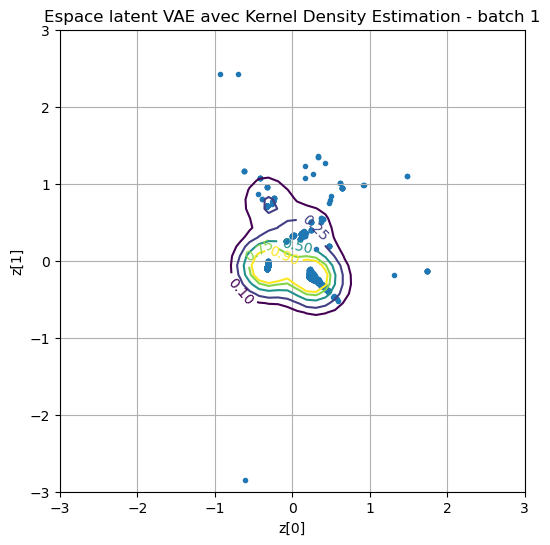

Process batch 2 de 1000 lignes
traite ligne 1000 du batch 2
entraîne VAE sur batch 2 --------------
kl_loss : 0.12
loss : 0.32
reconstruction_loss : 0.20


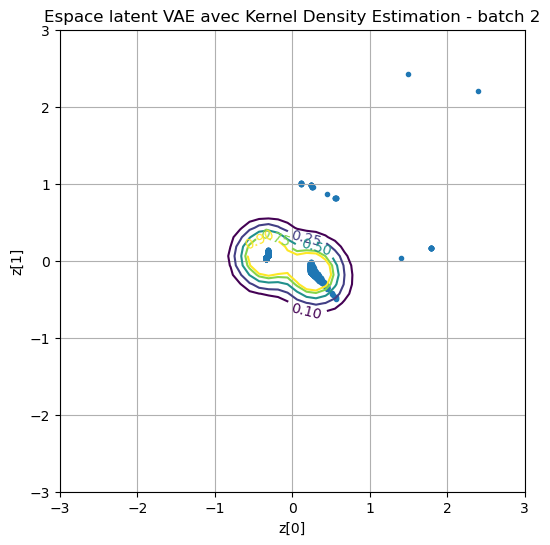

Process batch 3 de 1000 lignes
traite ligne 1000 du batch 3
entraîne VAE sur batch 3 --------------
kl_loss : 0.13
loss : 0.34
reconstruction_loss : 0.21


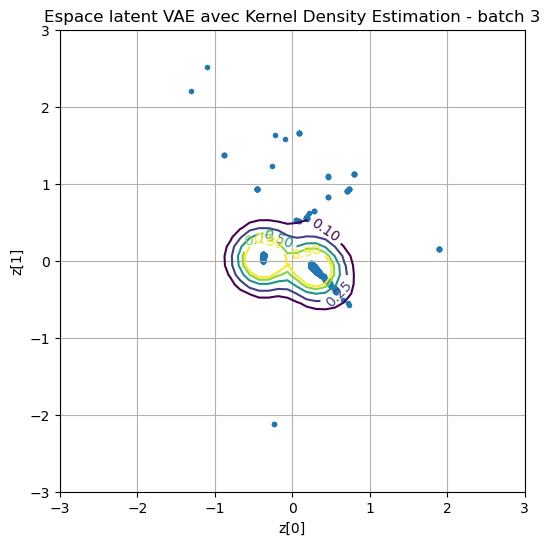

Process batch 4 de 1000 lignes
traite ligne 1000 du batch 4
entraîne VAE sur batch 4 --------------
kl_loss : 0.16
loss : 0.37
reconstruction_loss : 0.21


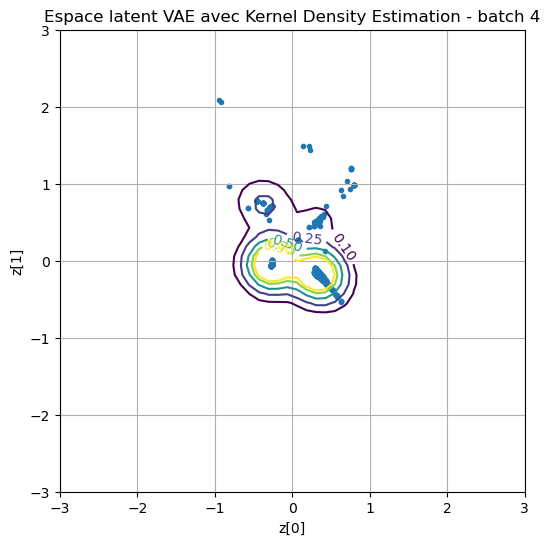

Process batch 5 de 1000 lignes
traite ligne 1000 du batch 5
entraîne VAE sur batch 5 --------------
kl_loss : 0.15
loss : 0.37
reconstruction_loss : 0.22


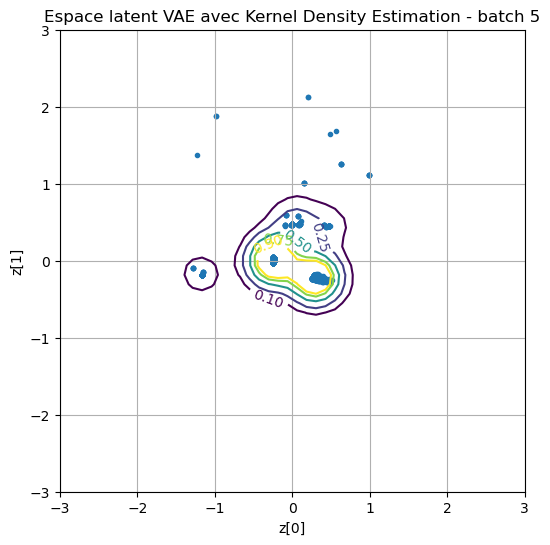

Process batch 6 de 1000 lignes
traite ligne 1000 du batch 6
entraîne VAE sur batch 6 --------------
kl_loss : 0.13
loss : 0.34
reconstruction_loss : 0.21


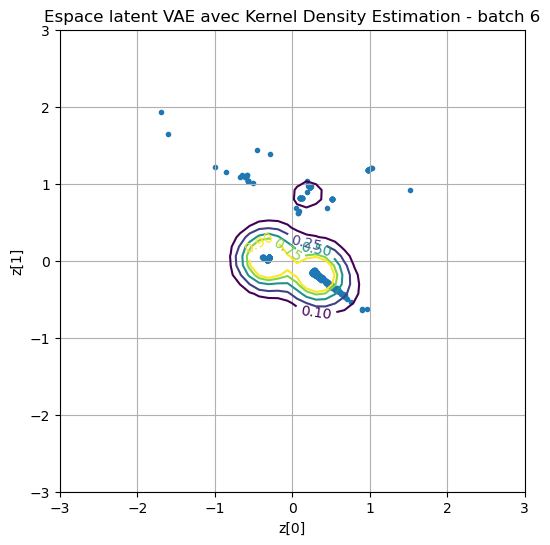

Process batch 7 de 1000 lignes
traite ligne 1000 du batch 7
entraîne VAE sur batch 7 --------------
kl_loss : 0.13
loss : 0.30
reconstruction_loss : 0.17


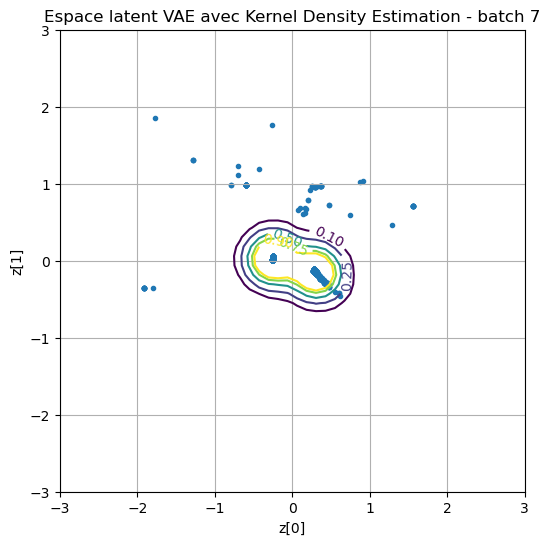

Process batch 8 de 1000 lignes
traite ligne 1000 du batch 8
entraîne VAE sur batch 8 --------------
kl_loss : 0.14
loss : 0.33
reconstruction_loss : 0.19


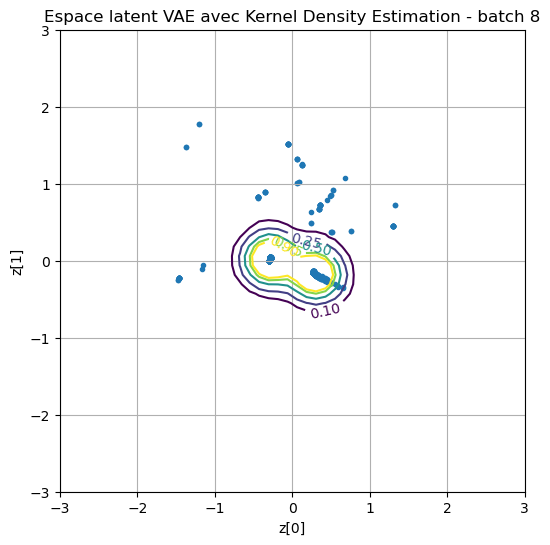

Process batch 9 de 1000 lignes
traite ligne 1000 du batch 9
entraîne VAE sur batch 9 --------------
kl_loss : 0.12
loss : 0.31
reconstruction_loss : 0.19


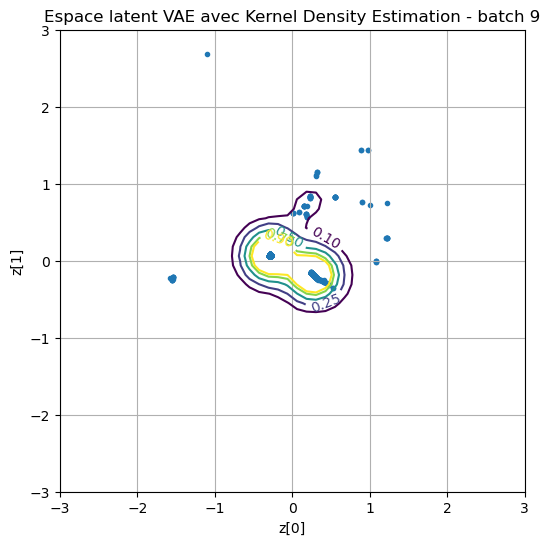

Process batch 10 de 1000 lignes
traite ligne 991 du batch 10
entraîne VAE sur batch 10 --------------
kl_loss : 0.13
loss : 0.27
reconstruction_loss : 0.14


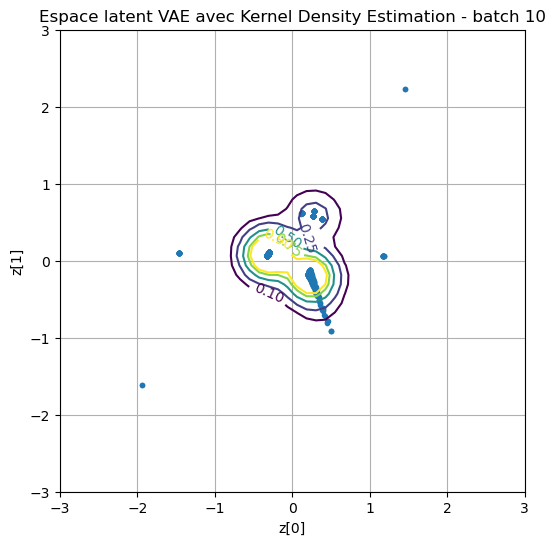

CPU times: user 6min 58s, sys: 26 s, total: 7min 24s
Wall time: 14min 27s


In [35]:
%%time

# Boucle training

# --- annonce la couleur
print(f"Processe {filename}\n")

# --- boucle
with open(file=filepath) as f:
    
    ctr_lines_total = 0
    ctr_batch = 1
    line = f.readline()
    
    while line != "":
        print(f"Process batch {ctr_batch} de {BATCH_SIZE} lignes")
        ctr_lines_in_batch = 0
        
        # --- inits pour le batch 
        # 1ere DataFrame : valeurs brutes (DEBUG ONLY)
        # dict_for_df_raw = { field : [] for field in list_fields }
        
        # 2e DataFrame : valeurs nettes
        dict_for_df = { field : [] for field in list_fields }
        
        # -- lit un batch, produit une DataFrame
        while (line != "") and (ctr_lines_in_batch<BATCH_SIZE):
            ctr_lines_in_batch += 1
            
            # - donne des nouvelles
            print(f"traite ligne {ctr_lines_in_batch} du batch {ctr_batch}", end="\r", flush=True)
            obj_json = json.loads(line)
            
            # - calcule à la main le UserNameDomainName
            obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
            
            # - trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
            for field in list_fields:
                val = obj_json.get(field, None)
                # dict_for_df_raw[field].append(val)
                dict_for_df[field].append(dico[field].get_field_categorical_value(val))
                
            # - ligne suivante
            line = f.readline()
            
        df = pd.DataFrame(dict_for_df)
        
        # -- training du VAE avec le nouveau batch
        points = df.to_numpy()
        print(f'\nentraîne VAE sur batch {ctr_batch} --------------')
        
        callback = tf.keras.callbacks.EarlyStopping(    # NB : il faut instancier le callback à chaque training
            monitor="loss",
            patience=10,
            restore_best_weights=True,
        )
        
        # scaling pour convergence VAE. Mais a priori différent par batch ! Hum.
        s = StandardScaler()
        points_red = s.fit_transform(points)
        
        history = vae.fit(points_red, epochs=1000, batch_size=32, callbacks=[callback], verbose=0)
        for o in list_outputs:
            val = history.history.get(o)[-1]
            print(f'{o} : {val:.2f}')
        
        # -- affiche projection du batch dans l'espace latent 
        titre = f'Espace latent VAE avec Kernel Density Estimation - batch {ctr_batch}'
        fig, ax = plot_label_clusters(vae, points_red, titre)
        savefig = video_rep + filename + f'_batch_{ctr_batch}.png'
        plt.savefig(savefig)  # enregistre jpg pour faire video avec ffmepg à l'issue
        # pour faire une video :
        # ffmpeg -r 1  -f image2 -s 640x640 -i wls_day-01_subset_nnnn.json_batch_%d.png -vcodec libx264 -crf 15 -pix_fmt yuv420p video.mp4
        # -r : frames per second
        plt.show()
        
        # -- prochain batch
        ctr_batch += 1
        line = f.readline()

### 2e méthode pour la représentation de l'espace latent : Bayesian Gaussian Mixture Model

Dans un GMM, les "responsabilités" (poids $\pi_{k}$ d'affectation à chacune des Gaussiennes dans $p(x)=\Sigma_{k=1}^{K} \pi_{k}\mathcal{N}(\mu_{k}, \Sigma_{k})$) sont des paramètres.

Dans le point de vue Bayesien, les responsabilités dérivent d'un prior conjugué qui est une distribution de Dirichlet en dimension finie, ou un processus de Dirichlet en dimension infinie. L'avantage du point de vue Bayesien est que le nombre de Gaussiennes du modèle est appris : on peut négliger les faibles responsabilités.

In [36]:
# Display projection de 'data' dans le latent space et clusterise avec un GMM Bayesien

def plot_label_clusters_GMM(vae, data, titre=None): #, labels):
    """Affiche en 2D la projection de data dans l'espace latent de vae

    Args:
        vae (_type_): modèle VAE
        labels (_type_): np.array 2D des points à afficher

    Returns:
        fig, ax
    """
    
    LIM = 3.0
    N_RESPONSIBILITIES_MAX = 20 # nombre maximum de Gaussiennes pour le GMM
    MIN_RESP_WEIGHT = 0.10 # seules les gaussiennes avec responsabilité >= MIn seront affichées
    NUM = 100 # nombre points pour affichage contour
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    # calculate projection of data on the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)

    # fit un variational GMM    
    dpbgm = BayesianGaussianMixture(
        n_components = N_RESPONSIBILITIES_MAX, # max number of components, will be infered by data
        weight_concentration_prior_type = 'dirichlet_process',   # weight concentration prior is Dirchlet process : (approximate) infinite number of components
        random_state = 42,
        # reg_covar = 1e-6,
        verbose = 3,
        max_iter = 1000,
    )
    
    dpbgm.fit(z_mean)
    
    # affiche plt.contour de chaque composant
    num_levels = 3
    x = np.linspace( -LIM, +LIM, num=NUM)
    y = np.linspace( -LIM, +LIM, num=NUM)
    X, Y = np.meshgrid(x, y) # X a shape NUm x NUM
    Z = np.zeros(shape=(NUM,NUM)) # ny,nx
    
    for w, (mu, sigma) in enumerate(zip(dpbgm.means_, dpbgm.covariances_)):
        resp = dpbgm.weights_[w]
        # print(f'resp = {resp}')
        if resp >= MIN_RESP_WEIGHT:
            print(f'affiche gaussienne {w}')
            mu = mu.reshape(-1,2)
            det_sigma = np.linalg.det(sigma)
            inv_sigma = np.linalg.inv(sigma)
            for j in range(NUM): # ny
                for k in range(NUM): # nx
                    xc = X[j,k]
                    yc = Y[j,k]
                    point = np.array([xc,yc]).reshape(-1,2)
                    # calcule la pdf au point xc,yc
                    delta = point-mu
                    delta.reshape(latent_dim, 1)
                    pdf = 1/((2*np.pi)**(latent_dim/2)*(det_sigma)**(1/2))*np.exp(-1/2*np.dot(delta, np.matmul(inv_sigma, np.transpose(delta))))
                    Z[j,k] = pdf
            cs = ax.contour(X,Y,Z,num_levels)
            ax.clabel(cs, inline=True, fontsize=10)  # affiche log probas
    
    # trace nuage de points projetés dans l'espace latent
    ax.scatter(z_mean[:, 0], z_mean[:, 1], marker='.') 
    ax.set_xlabel("z[0]")
    ax.set_xlim(left=-LIM, right=+LIM)
    ax.set_ylabel("z[1]")
    ax.set_ylim(bottom=-LIM, top=+LIM)
    
    if titre==None:
        titre = 'Espace latent VAE'
    ax.set_title(titre)
    ax.grid(True)
        
    return fig, ax

In [37]:
# instancie modèle, prêt au training

vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())

In [38]:
# Paramètres pour training séquentiel

# ---- batch -----
BATCH_SIZE = 1000 # batch de lignes que l'on va lire par training

# ---- choisit le fichier
dirpath = DIRPATH
filename = 'wls_day-01_subset_10000.json'
filepath = dirpath + filename

# ---- outputs modèle
list_outputs = ['kl_loss', 'loss', 'reconstruction_loss']

# --- pour faire une video
video_rep = os.getcwd() + '/data/jpg_for_videos/'

Processe wls_day-01_subset_10000.json

Process batch 1 de 1000 lignes
traite ligne 1000 du batch 1
entraîne VAE sur batch 1 --------------
kl_loss : 0.16
loss : 0.41
reconstruction_loss : 0.25
Initialization 0
  Iteration 10	 time lapse 1.32382s	 ll change 2.65408
  Iteration 20	 time lapse 0.30852s	 ll change 0.00285
Initialization converged: True	 time lapse 1.67321s	 ll 3717.20736
affiche gaussienne 1
affiche gaussienne 2


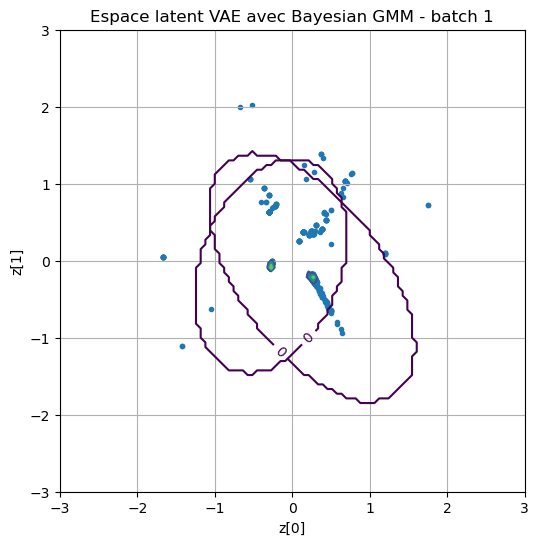

Process batch 2 de 1000 lignes
traite ligne 1000 du batch 2
entraîne VAE sur batch 2 --------------
kl_loss : 0.11
loss : 0.25
reconstruction_loss : 0.14
Initialization 0
  Iteration 10	 time lapse 0.60805s	 ll change 0.11864
  Iteration 20	 time lapse 0.33866s	 ll change 32.38893
Initialization converged: True	 time lapse 1.10842s	 ll 5139.27518
affiche gaussienne 1
affiche gaussienne 18


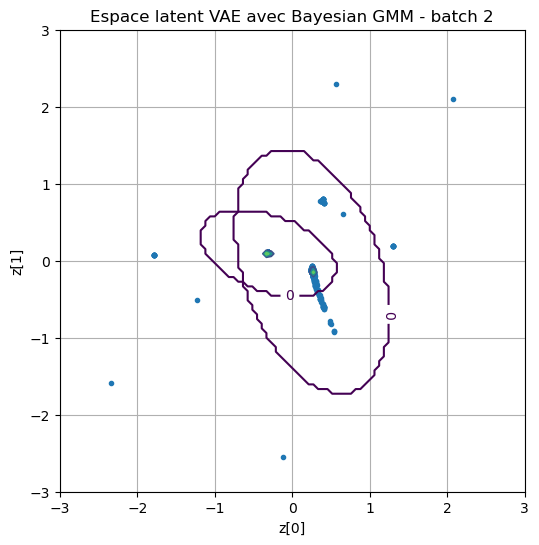

Process batch 3 de 1000 lignes
traite ligne 1000 du batch 3
entraîne VAE sur batch 3 --------------
kl_loss : 0.12
loss : 0.37
reconstruction_loss : 0.25
Initialization 0
  Iteration 10	 time lapse 0.54742s	 ll change 1.40114
  Iteration 20	 time lapse 0.47587s	 ll change 0.09951
  Iteration 30	 time lapse 0.36825s	 ll change 0.00014
Initialization converged: True	 time lapse 1.39195s	 ll 4775.98987
affiche gaussienne 0
affiche gaussienne 1


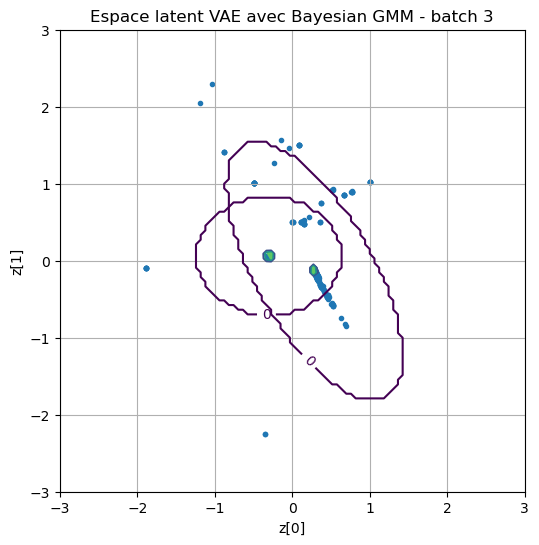

Process batch 4 de 1000 lignes
traite ligne 1000 du batch 4
entraîne VAE sur batch 4 --------------
kl_loss : 0.15
loss : 0.35
reconstruction_loss : 0.19
Initialization 0
  Iteration 10	 time lapse 0.82997s	 ll change 8.26868
  Iteration 20	 time lapse 1.00521s	 ll change 6.18479
Initialization converged: True	 time lapse 1.96841s	 ll 4089.17394
affiche gaussienne 0
affiche gaussienne 19


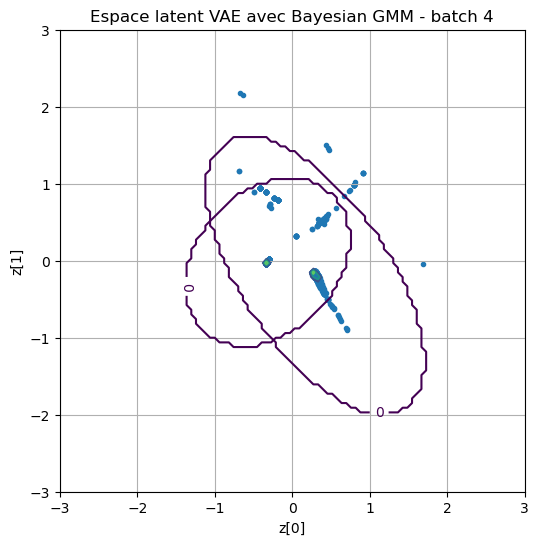

Process batch 5 de 1000 lignes
traite ligne 1000 du batch 5
entraîne VAE sur batch 5 --------------
kl_loss : 0.16
loss : 0.35
reconstruction_loss : 0.20
Initialization 0
  Iteration 10	 time lapse 0.70716s	 ll change 5.08502
  Iteration 20	 time lapse 0.38783s	 ll change 0.76767
  Iteration 30	 time lapse 0.75370s	 ll change 0.00064
Initialization converged: True	 time lapse 1.84896s	 ll 4030.84281
affiche gaussienne 1
affiche gaussienne 14


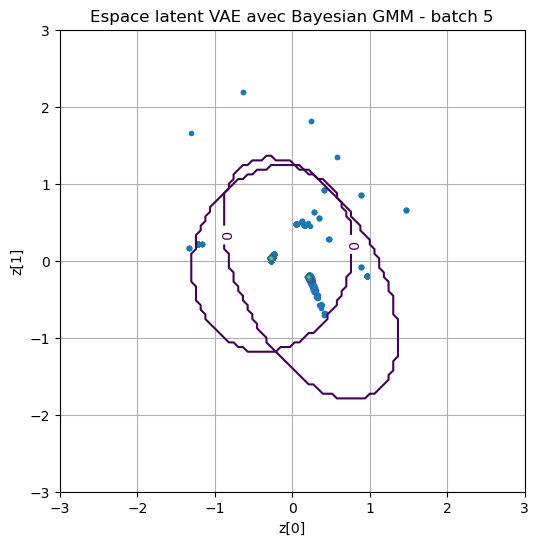

Process batch 6 de 1000 lignes
traite ligne 1000 du batch 6
entraîne VAE sur batch 6 --------------
kl_loss : 0.13
loss : 0.34
reconstruction_loss : 0.21
Initialization 0
  Iteration 10	 time lapse 0.87793s	 ll change 2.62737
Initialization converged: True	 time lapse 1.40442s	 ll 4866.06260
affiche gaussienne 0
affiche gaussienne 1


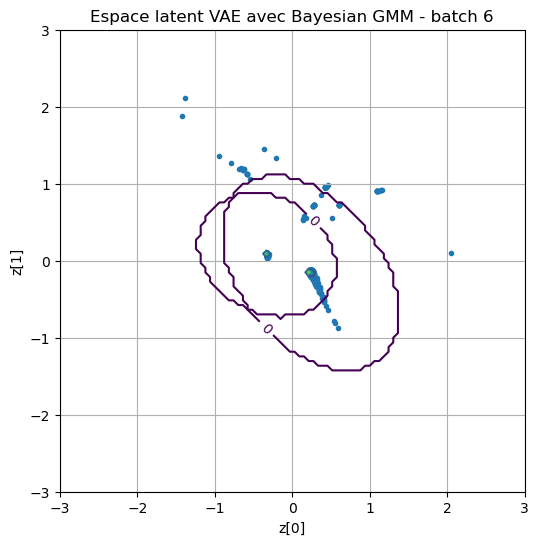

Process batch 7 de 1000 lignes
traite ligne 1000 du batch 7
entraîne VAE sur batch 7 --------------
kl_loss : 0.15
loss : 0.31
reconstruction_loss : 0.16
Initialization 0
  Iteration 10	 time lapse 0.69451s	 ll change 2.31322
Initialization converged: True	 time lapse 1.01774s	 ll 5013.59040
affiche gaussienne 0
affiche gaussienne 1


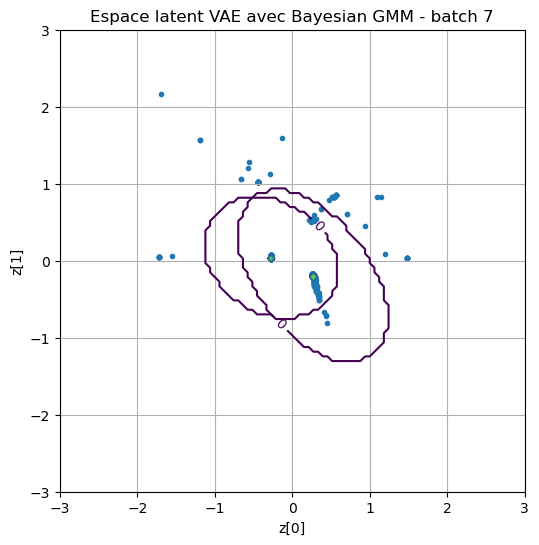

Process batch 8 de 1000 lignes
traite ligne 1000 du batch 8
entraîne VAE sur batch 8 --------------
kl_loss : 0.14
loss : 0.36
reconstruction_loss : 0.22
Initialization 0
  Iteration 10	 time lapse 0.77499s	 ll change 1.64480
Initialization converged: True	 time lapse 1.29597s	 ll 4770.42992
affiche gaussienne 1
affiche gaussienne 18


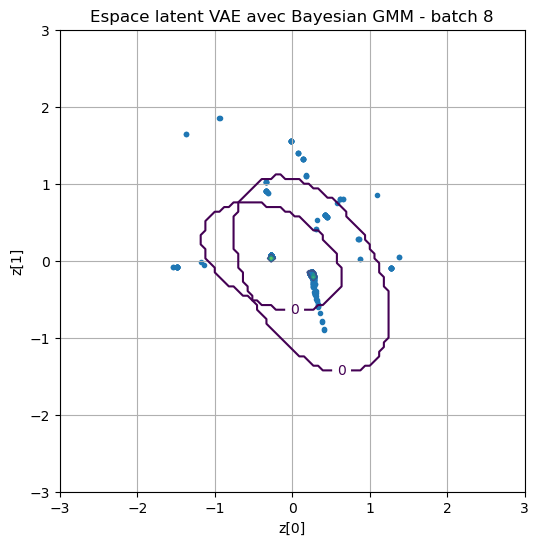

Process batch 9 de 1000 lignes
traite ligne 1000 du batch 9
entraîne VAE sur batch 9 --------------
kl_loss : 0.13
loss : 0.35
reconstruction_loss : 0.23
Initialization 0
  Iteration 10	 time lapse 0.68008s	 ll change 3.89517
Initialization converged: True	 time lapse 1.25083s	 ll 5003.85354
affiche gaussienne 1
affiche gaussienne 13


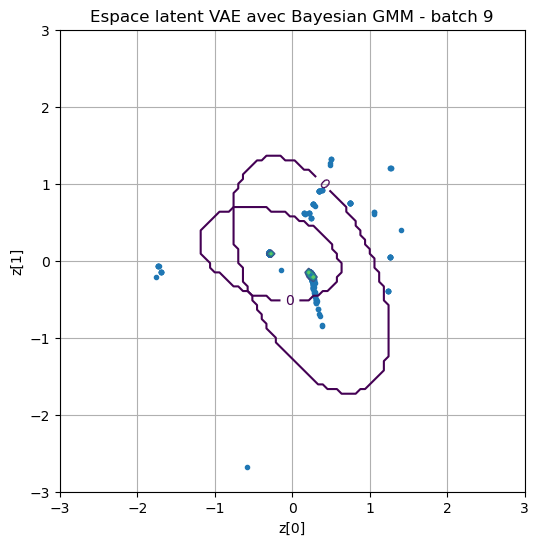

Process batch 10 de 1000 lignes
traite ligne 991 du batch 10
entraîne VAE sur batch 10 --------------
kl_loss : 0.13
loss : 0.29
reconstruction_loss : 0.16
Initialization 0
  Iteration 10	 time lapse 0.65425s	 ll change 19.50729
  Iteration 20	 time lapse 0.59152s	 ll change 1.38875
Initialization converged: True	 time lapse 1.90893s	 ll 4235.03428
affiche gaussienne 0
affiche gaussienne 18


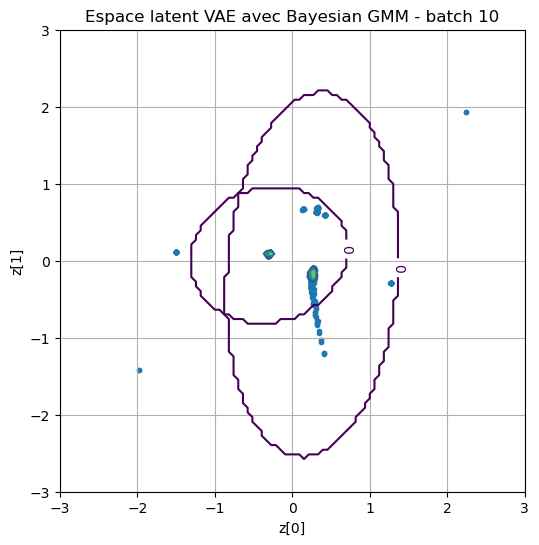

CPU times: user 5min 44s, sys: 22.8 s, total: 6min 6s
Wall time: 12min 35s


In [39]:
%%time

# Boucle training

# --- annonce la couleur
print(f"Processe {filename}\n")

# --- boucle
with open(file=filepath) as f:
    
    ctr_lines_total = 0
    ctr_batch = 1
    line = f.readline()
    
    while line != "":
        print(f"Process batch {ctr_batch} de {BATCH_SIZE} lignes")
        ctr_lines_in_batch = 0
        
        # --- inits pour le batch 
        # 1ere DataFrame : valeurs brutes (DEBUG ONLY)
        # dict_for_df_raw = { field : [] for field in list_fields }
        
        # 2e DataFrame : valeurs nettes
        dict_for_df = { field : [] for field in list_fields }
        
        # -- lit un batch, produit une DataFrame
        while (line != "") and (ctr_lines_in_batch<BATCH_SIZE):
            ctr_lines_in_batch += 1
            
            # - donne des nouvelles
            print(f"traite ligne {ctr_lines_in_batch} du batch {ctr_batch}", end="\r", flush=True)
            obj_json = json.loads(line)
            
            # - calcule à la main le UserNameDomainName
            obj_json['UserNameDomainName'] = obj_json.get('UserName') + obj_json.get('DomainName')
            
            # - trouve la valeur de chaque champ (éventuellement None) et traduit en categorical value suivant dictionnaire dico
            for field in list_fields:
                val = obj_json.get(field, None)
                # dict_for_df_raw[field].append(val)
                dict_for_df[field].append(dico[field].get_field_categorical_value(val))
                
            # - ligne suivante
            line = f.readline()
            
        df = pd.DataFrame(dict_for_df)
        
        # -- training du VAE avec le nouveau batch
        points = df.to_numpy()
        print(f'\nentraîne VAE sur batch {ctr_batch} --------------')
        
        callback = tf.keras.callbacks.EarlyStopping(    # NB : il faut instancier le callback à chaque training
            monitor="loss",
            patience=10,
            restore_best_weights=True,
        )
        
        # scaling pour convergence VAE. Mais a priori différent par batch ! Hum.
        s = StandardScaler()
        points_red = s.fit_transform(points)
        
        history = vae.fit(points_red, epochs=1000, batch_size=32, callbacks=[callback], verbose=0)
        for o in list_outputs:
            val = history.history.get(o)[-1]
            print(f'{o} : {val:.2f}')
        
        # -- affiche projection du batch dans l'espace latent 
        titre = f'Espace latent VAE avec Bayesian GMM - batch {ctr_batch}'
        fig, ax = plot_label_clusters_GMM(vae, points_red, titre)
        savefig = video_rep + filename + f'_GMM_batch_{ctr_batch}.png'
        plt.savefig(savefig)  # enregistre jpg pour faire video avec ffmepg à l'issue
        # pour faire une video :
        # ffmpeg -r 1  -f image2 -s 640x640 -i wls_day-01_subset_nnnn.json_batch_%d.png -vcodec libx264 -crf 15 -pix_fmt yuv420p video.mp4
        # -r : frames per second
        plt.show()
        
        # -- prochain batch
        ctr_batch += 1
        line = f.readline()
        

# Conclusions

La difficulté principale de l'apprentissage non supervisé séquentiel en cyber est de garder la mémoire de la distribution de probabilité du training set, sans pouvoir garder en mémoire tous les points constituant ce training set.

Idéalement, cette vue "agrégée" de la distribution du training set doit être mise à jour au fur et à mesure des batchs de nouveaux points, pour minimiser autant que faire se peut le drift. La solution dans ce notebook est de fitter un VAE.

On peut alors calculer une densité de probabilité de chaque nouveau point dans cette distrIbution agrégée, pour juger d'une éventuelle anomalie.